In [6]:
#load library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter
from tqdm.auto import tqdm
from nltk.corpus import stopwords
tqdm.pandas()

In [7]:
#load dataset
df = pd.read_csv('dataset_reduced.csv', encoding = 'utf-8',)
df.head()

,text,labels
0,cultural amp critical studies alhamdulillah su...,0
1,rambut benar warna kadang oren kadang coklat m...,0
2,segi pandang agama anggap agama irasional tida...,0
3,itu pasu nasi bungkus,0
4,asa monyet tidak,0


In [8]:
#pastikan tipe data pada kolom text dan labels
df['text'] = df['text'].astype(str)
df['labels'] = df['labels'].astype(int)

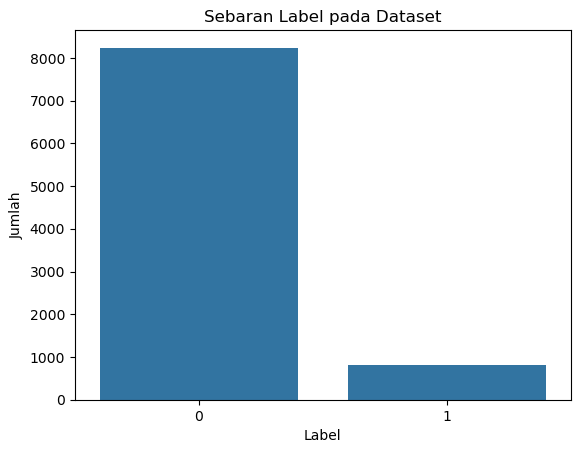

labels
0    8237
1     823
Name: count, dtype: int64

In [9]:
#lihat sebaran label pada dataset
sns.countplot(x='labels', data=df)
plt.title('Sebaran Label pada Dataset')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()
#Cek jumlah data pada setiap label
df['labels'].value_counts()

In [10]:
# untuk test hasil model terhadap dataset super imbalanced, dosbim meminta untuk mengurangi jumlah label data 1 menjadi 10% dari label 0
# Mengurangi jumlah label 1 menjadi 10% dari label 0
def reduce_label_1(df, target_ratio=0.1):
    count_0 = df[df['labels'] == 0].shape[0]
    count_1 = df[df['labels'] == 1].shape[0]
    
    # Hitung jumlah label 1 yang diinginkan
    target_count_1 = int(count_0 * target_ratio)
    
    # Ambil subset dari label 1
    df_label_1 = df[df['labels'] == 1].sample(n=target_count_1, random_state=42)
    
    # Gabungkan dengan label 0
    df_reduced = pd.concat([df[df['labels'] == 0], df_label_1])
    
    return df_reduced

***PERSIAPKAN WORD-EMBEDDING FASTTEXT***

In [11]:
#load model pre-trained FastText
model_path = 'cc.id.300.bin'

import fasttext
ft_model = fasttext.load_model(model_path)

print(ft_model.get_dimension())
print(ft_model.get_word_vector("saya")[:10])  # Cek vektor kata

300
[-0.01407608  0.06523435  0.04372576  0.18425423  0.02241408 -0.11397391
 -0.04704365  0.02331188 -0.02006736 -0.05753721]


In [12]:
df = df.dropna(subset=['text'])

In [13]:
#definisikan X dan y
X = df['text'].tolist()
y = df['labels'].values

#tokenisasi teks
max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print(f"Jumlah kata unik dalam kamus: {len(word_index)}")

# Mengonversi teks menjadi urutan indeks
sequences = tokenizer.texts_to_sequences(X)

# Padding urutan untuk memastikan panjang yang konsisten
maxlen = max(len(seq) for seq in sequences)
print(f"Panjang maksimum urutan: {maxlen}")

# Padding urutan
X_padded = pad_sequences(sequences, maxlen=maxlen, padding='post')

Jumlah kata unik dalam kamus: 11669
Panjang maksimum urutan: 52


Text(0.5, 1.0, 'Distribusi Panjang Teks')

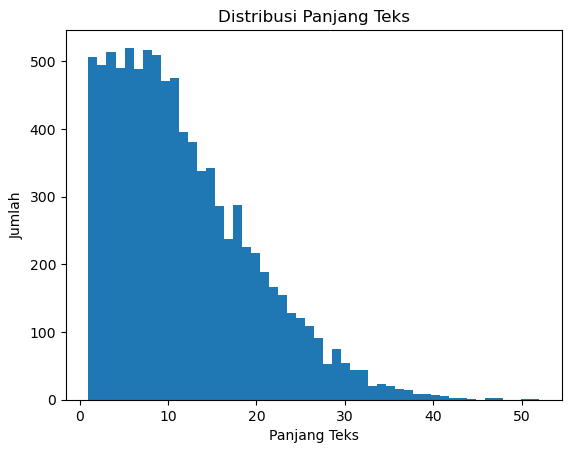

In [14]:
#analisis distribusi panjang kata untuk maxlen
plt.hist([len(seq) for seq in sequences], bins=50)
plt.xlabel('Panjang Teks'); plt.ylabel('Jumlah'); plt.title('Distribusi Panjang Teks')

In [15]:
# Membuat matriks embedding
embedding_dim = ft_model.get_dimension()
num_tokens = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_tokens, embedding_dim))
words_not_found = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    if i >= num_tokens:
        continue
    embedding_matrix[i] = ft_model.get_word_vector(word)

print(f"Dimensi matriks embedding: {embedding_matrix.shape}")

Dimensi matriks embedding: (11670, 300)


***DEFINISIKAN ARSITEKTUR MODEL BiLSTM***

In [16]:
# Definisikan hyperparameter untuk model LSTM
lstm_units = 128                                    # Jumlah unit LSTM
dense_units = 64                                    # Jumlah unit pada lapisan dense
dropout_rate = 0.5                                  # Tingkat dropout untuk regularisasi
learning_rate = 0.001                               # Tingkat pembelajaran awal untuk optimizer Adam
epochs = 10                                         # Jumlah epoch pelatihan
batch_size = 64                                     # Ukuran batch untuk pelatihan

In [17]:
# Bangun model LSTM
def build_lstm_model(num_tokens, embedding_dim, maxlen, embedding_matrix, lstm_units, dense_units, dropout_rate):
    model = Sequential()
    
    model.add(Embedding(input_dim=num_tokens,
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=maxlen,
                        trainable=False))
    
    #Lapisan BiLSTM untuk menangkap konteks dari kedua arah
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))  # Dropout untuk regularisasi

    #Lapisan Dense dengan aktivasi ReLU
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout untuk regularisasi

    #Lapisan output dengan aktivasi sigmoid untuk klasifikasi biner
    model.add(Dense(1, activation='sigmoid'))

    return model

# Inisialisasi model
model = build_lstm_model(num_tokens, embedding_dim, maxlen, embedding_matrix, lstm_units, dense_units, dropout_rate)
# Bangun model secara eksplisit dengan menentukan input_shape
model.build(input_shape=(None, maxlen))
model.summary()

c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 52, 300)        │     3,501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,956,809 (15.09 MB)

 Trainable params: 455,809 (1.74 MB)

 Non-trainable params: 3,501,000 (13.36 MB)

In [18]:
# Compile model
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),]

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
print("Model telah dicompile.")

Model telah dicompile.


***PELATIHAN DAN EVALUASI MODEL***

In [19]:
#Definisikan X dan y untuk model pelatihan dan evaluasi
X_cv = X_padded
y_cv = y

print(f"Total data instances for Cross-Validation: {len(X_cv)}")
print(f"Overall data distribution for Cross-Validation: {Counter(y_cv)}")

Total data instances for Cross-Validation: 9060
Overall data distribution for Cross-Validation: Counter({0: 8237, 1: 823})


In [20]:
#Definisikan Fungsi untuk Melatih dan Mengevaluasi Model pada Satu Fold
def train_and_evaluate_single_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold_idx, technique_name):
    print(f"\n===== Training and Evaluating {technique_name} - Fold {fold_idx+1} =====")
    
    # Rebuild model to ensure fresh weights for each fold
    model = build_lstm_model(num_tokens, embedding_dim, maxlen, embedding_matrix, lstm_units, dense_units, dropout_rate)
    model.build(input_shape=(None, maxlen))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Metrik untuk kompilasi model di dalam fungsi ini
    METRICS_FOLD = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'), 
        tf.keras.metrics.Recall(name='recall'),
    ]
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=METRICS_FOLD)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True, verbose=1) 
    
    # Pastikan tipe data numerik yang benar untuk TensorFlow
    X_train_fold = X_train_fold.astype(np.float32)
    y_train_fold = y_train_fold.astype(np.int32)
    X_val_fold = X_val_fold.astype(np.float32)
    y_val_fold = y_val_fold.astype(np.int32)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_fold, y_val_fold), # Gunakan validation_data langsung 
                        callbacks=[early_stopping], # Tambahkan callback EarlyStopping di sini
                        verbose=1)
    
    # Make predictions on the validation fold
    y_pred_prob = model.predict(X_val_fold)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics for this fold
    accuracy = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred, zero_division=0)
    recall = recall_score(y_val_fold, y_pred, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, zero_division=0)
    
    print(f"Fold {fold_idx+1} Metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}")
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1, 'y_true': y_val_fold, 'y_pred': y_pred}


--- Starting 5-Fold Cross-Validation for Random Oversampling ---


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Resampled training set distribution (Random Oversampling): Counter({0: 6589, 1: 6589})

===== Training and Evaluating Random Oversampling - Fold 1 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 149ms/step - accuracy: 0.6405 - loss: 0.6223 - precision: 0.6280 - recall: 0.7157 - val_accuracy: 0.7340 - val_loss: 0.5106 - val_precision: 0.2211 - val_recall: 0.7683
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 180ms/step - accuracy: 0.8011 - loss: 0.4432 - precision: 0.7748 - recall: 0.8411 - val_accuracy: 0.7737 - val_loss: 0.4617 - val_precision: 0.2510 - val_recall: 0.7561
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 59s 286ms/step - accuracy: 0.8473 - loss: 0.3525 - precision: 0.8151 - recall: 0.8975 - val_accuracy: 0.8140 - val_loss: 0.4155 - val_precision: 0.2765 - val_recall: 0.6524
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 61s 297ms/step - accuracy: 0.8904 - loss: 0.2762 - precision: 0.8628 - recall: 0.9294 - val_accuracy: 0.7368 - val_loss: 0.5686 - val_precision: 0.2210 - val_recall: 0.7561
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 219ms/step - accuracy: 0.9089 - loss: 0.2398 - precision: 0.8787 - recall: 0.9488 - val_accuracy: 0.8405

 20%|██        | 1/5 [04:43<18:54, 283.56s/it]

Fold 1 Metrics: Accuracy=0.8140, Precision=0.2765, Recall=0.6524, F1-Score=0.3884
Waktu untuk Random Oversampling: 283.59 detik
Fold 2 - Resampled training set distribution (Random Oversampling): Counter({0: 6589, 1: 6589})

===== Training and Evaluating Random Oversampling - Fold 2 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 195ms/step - accuracy: 0.6577 - loss: 0.6136 - precision: 0.6605 - recall: 0.6322 - val_accuracy: 0.7671 - val_loss: 0.4647 - val_precision: 0.2420 - val_recall: 0.7378
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 57s 275ms/step - accuracy: 0.8091 - loss: 0.4300 - precision: 0.7890 - recall: 0.8469 - val_accuracy: 0.7130 - val_loss: 0.5530 - val_precision: 0.2129 - val_recall: 0.8049
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 251ms/step - accuracy: 0.8555 - loss: 0.3470 - precision: 0.8283 - recall: 0.8959 - val_accuracy: 0.8295 - val_loss: 0.3943 - val_precision: 0.2958 - val_recall: 0.6402
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 249ms/step - accuracy: 0.8651 - loss: 0.3225 - precision: 0.8332 - recall: 0.9070 - val_accuracy: 0.7908 - val_loss: 0.5305 - val_precision: 0.2482 - val_recall: 0.6463
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step - accuracy: 0.9109 - loss: 0.2324 - precision: 0.8799 - recall: 0.9493 - val_accuracy: 0.8389

 40%|████      | 2/5 [10:05<15:17, 305.88s/it]

Fold 2 Metrics: Accuracy=0.8295, Precision=0.2958, Recall=0.6402, F1-Score=0.4046
Waktu untuk Random Oversampling: 605.10 detik
Fold 3 - Resampled training set distribution (Random Oversampling): Counter({0: 6590, 1: 6590})

===== Training and Evaluating Random Oversampling - Fold 3 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 60s 261ms/step - accuracy: 0.6450 - loss: 0.6139 - precision: 0.6522 - recall: 0.5827 - val_accuracy: 0.7014 - val_loss: 0.5430 - val_precision: 0.2035 - val_recall: 0.7818
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.8046 - loss: 0.4316 - precision: 0.7816 - recall: 0.8362 - val_accuracy: 0.7605 - val_loss: 0.4981 - val_precision: 0.2305 - val_recall: 0.6970
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 56s 274ms/step - accuracy: 0.8617 - loss: 0.3275 - precision: 0.8320 - recall: 0.9074 - val_accuracy: 0.7417 - val_loss: 0.5807 - val_precision: 0.2179 - val_recall: 0.7091
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 247ms/step - accuracy: 0.8907 - loss: 0.2736 - precision: 0.8570 - recall: 0.9372 - val_accuracy: 0.7704 - val_loss: 0.5735 - val_precision: 0.2301 - val_recall: 0.6485
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 247ms/step - accuracy: 0.9182 - loss: 0.2099 - precision: 0.8933 - recall: 0.9518 - val_accuracy: 0.7577

 60%|██████    | 3/5 [14:39<09:42, 291.31s/it]

Fold 3 Metrics: Accuracy=0.7605, Precision=0.2305, Recall=0.6970, F1-Score=0.3464
Waktu untuk Random Oversampling: 879.06 detik
Fold 4 - Resampled training set distribution (Random Oversampling): Counter({0: 6590, 1: 6590})

===== Training and Evaluating Random Oversampling - Fold 4 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - accuracy: 0.6571 - loss: 0.6130 - precision: 0.6456 - recall: 0.7108 - val_accuracy: 0.7759 - val_loss: 0.4564 - val_precision: 0.2515 - val_recall: 0.7394
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - accuracy: 0.8175 - loss: 0.4235 - precision: 0.7921 - recall: 0.8573 - val_accuracy: 0.7964 - val_loss: 0.4217 - val_precision: 0.2639 - val_recall: 0.6909
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 249ms/step - accuracy: 0.8428 - loss: 0.3623 - precision: 0.8189 - recall: 0.8829 - val_accuracy: 0.8311 - val_loss: 0.4282 - val_precision: 0.2968 - val_recall: 0.6242
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 244ms/step - accuracy: 0.8814 - loss: 0.2998 - precision: 0.8500 - recall: 0.9292 - val_accuracy: 0.8659 - val_loss: 0.3940 - val_precision: 0.3347 - val_recall: 0.4788
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.9036 - loss: 0.2367 - precision: 0.8778 - recall: 0.9364 - val_accuracy: 0.8162

 80%|████████  | 4/5 [20:47<05:21, 321.64s/it]

Fold 4 Metrics: Accuracy=0.8659, Precision=0.3347, Recall=0.4788, F1-Score=0.3940
Waktu untuk Random Oversampling: 1247.19 detik
Fold 5 - Resampled training set distribution (Random Oversampling): Counter({0: 6590, 1: 6590})

===== Training and Evaluating Random Oversampling - Fold 5 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 222ms/step - accuracy: 0.6379 - loss: 0.6132 - precision: 0.6342 - recall: 0.6633 - val_accuracy: 0.7776 - val_loss: 0.4633 - val_precision: 0.2561 - val_recall: 0.7576
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 245ms/step - accuracy: 0.8214 - loss: 0.4097 - precision: 0.7983 - recall: 0.8603 - val_accuracy: 0.7428 - val_loss: 0.5252 - val_precision: 0.2259 - val_recall: 0.7515
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 244ms/step - accuracy: 0.8544 - loss: 0.3418 - precision: 0.8252 - recall: 0.9023 - val_accuracy: 0.8030 - val_loss: 0.4514 - val_precision: 0.2624 - val_recall: 0.6424
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 237ms/step - accuracy: 0.8956 - loss: 0.2675 - precision: 0.8617 - recall: 0.9402 - val_accuracy: 0.8560 - val_loss: 0.3693 - val_precision: 0.3195 - val_recall: 0.5152
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 248ms/step - accuracy: 0.9237 - loss: 0.2163 - precision: 0.8938 - recall: 0.9596 - val_accuracy: 0.8400

100%|██████████| 5/5 [26:40<00:00, 320.19s/it]


Fold 5 Metrics: Accuracy=0.8560, Precision=0.3195, Recall=0.5152, F1-Score=0.3944
Waktu untuk Random Oversampling: 1600.96 detik

Average Metrics for Random Oversampling across 5 folds:
{'accuracy': 0.8251655629139073, 'precision': 0.29140319854740443, 'recall': 0.5967184035476719, 'f1_score': 0.3855682183468252, 'technique': 'Random Oversampling'}

--- Starting 5-Fold Cross-Validation for SMOTE ---


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Resampled training set distribution (SMOTE): Counter({0: 6589, 1: 6589})

===== Training and Evaluating SMOTE - Fold 1 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 62s 278ms/step - accuracy: 0.5220 - loss: 0.6906 - precision: 0.5220 - recall: 0.6508 - val_accuracy: 0.5408 - val_loss: 0.6420 - val_precision: 0.1222 - val_recall: 0.6585
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 228ms/step - accuracy: 0.6754 - loss: 0.6064 - precision: 0.6503 - recall: 0.7383 - val_accuracy: 0.6992 - val_loss: 0.5239 - val_precision: 0.1664 - val_recall: 0.5793
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 223ms/step - accuracy: 0.7370 - loss: 0.5358 - precision: 0.7178 - recall: 0.7833 - val_accuracy: 0.7042 - val_loss: 0.5238 - val_precision: 0.1760 - val_recall: 0.6159
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.7705 - loss: 0.4748 - precision: 0.7535 - recall: 0.8013 - val_accuracy: 0.7710 - val_loss: 0.4552 - val_precision: 0.2061 - val_recall: 0.5366
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 235ms/step - accuracy: 0.8019 - loss: 0.4257 - precision: 0.7904 - recall: 0.8258 - val_accuracy: 0.6948 - val_loss

 20%|██        | 1/5 [08:26<33:45, 506.37s/it]

Fold 1 Metrics: Accuracy=0.8079, Precision=0.2125, Recall=0.4146, F1-Score=0.2810
Waktu untuk SMOTE: 506.38 detik
Fold 2 - Resampled training set distribution (SMOTE): Counter({0: 6589, 1: 6589})

===== Training and Evaluating SMOTE - Fold 2 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 58s 260ms/step - accuracy: 0.5087 - loss: 0.6923 - precision: 0.5054 - recall: 0.6202 - val_accuracy: 0.5469 - val_loss: 0.6884 - val_precision: 0.1386 - val_recall: 0.7683
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 212ms/step - accuracy: 0.6237 - loss: 0.6483 - precision: 0.6049 - recall: 0.6703 - val_accuracy: 0.6043 - val_loss: 0.6784 - val_precision: 0.1423 - val_recall: 0.6707
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - accuracy: 0.7264 - loss: 0.5417 - precision: 0.7122 - recall: 0.7644 - val_accuracy: 0.7125 - val_loss: 0.5522 - val_precision: 0.1713 - val_recall: 0.5671
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 56s 269ms/step - accuracy: 0.7640 - loss: 0.4903 - precision: 0.7531 - recall: 0.7875 - val_accuracy: 0.7263 - val_loss: 0.5511 - val_precision: 0.1732 - val_recall: 0.5366
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - accuracy: 0.7948 - loss: 0.4451 - precision: 0.7829 - recall: 0.8176 - val_accuracy: 0.7241

 40%|████      | 2/5 [17:08<25:47, 515.76s/it]

Fold 2 Metrics: Accuracy=0.8085, Precision=0.2114, Recall=0.4085, F1-Score=0.2786
Waktu untuk SMOTE: 1028.71 detik
Fold 3 - Resampled training set distribution (SMOTE): Counter({0: 6590, 1: 6590})

===== Training and Evaluating SMOTE - Fold 3 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 57s 252ms/step - accuracy: 0.5094 - loss: 0.6928 - precision: 0.5106 - recall: 0.6059 - val_accuracy: 0.4989 - val_loss: 0.6838 - val_precision: 0.1281 - val_recall: 0.7758
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 263ms/step - accuracy: 0.6182 - loss: 0.6541 - precision: 0.6037 - recall: 0.6878 - val_accuracy: 0.6175 - val_loss: 0.6109 - val_precision: 0.1452 - val_recall: 0.6545
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - accuracy: 0.7127 - loss: 0.5585 - precision: 0.6862 - recall: 0.7660 - val_accuracy: 0.6115 - val_loss: 0.6610 - val_precision: 0.1468 - val_recall: 0.6788
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.7582 - loss: 0.4967 - precision: 0.7435 - recall: 0.7913 - val_accuracy: 0.7853 - val_loss: 0.4467 - val_precision: 0.1818 - val_recall: 0.3879
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 58s 279ms/step - accuracy: 0.7822 - loss: 0.4628 - precision: 0.7705 - recall: 0.8032 - val_accuracy: 0.7219

 60%|██████    | 3/5 [23:23<15:02, 451.18s/it]

Fold 3 Metrics: Accuracy=0.7853, Precision=0.1818, Recall=0.3879, F1-Score=0.2476
Waktu untuk SMOTE: 1403.04 detik
Fold 4 - Resampled training set distribution (SMOTE): Counter({0: 6590, 1: 6590})

===== Training and Evaluating SMOTE - Fold 4 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/step - accuracy: 0.5095 - loss: 0.6915 - precision: 0.5099 - recall: 0.5692 - val_accuracy: 0.4978 - val_loss: 0.7153 - val_precision: 0.1294 - val_recall: 0.7879
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 263ms/step - accuracy: 0.6711 - loss: 0.6092 - precision: 0.6572 - recall: 0.7025 - val_accuracy: 0.5977 - val_loss: 0.6633 - val_precision: 0.1366 - val_recall: 0.6424
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 251ms/step - accuracy: 0.7415 - loss: 0.5259 - precision: 0.7231 - recall: 0.7839 - val_accuracy: 0.6600 - val_loss: 0.6209 - val_precision: 0.1525 - val_recall: 0.6000
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.7709 - loss: 0.4767 - precision: 0.7620 - recall: 0.7818 - val_accuracy: 0.7517 - val_loss: 0.5221 - val_precision: 0.1895 - val_recall: 0.5273
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 268ms/step - accuracy: 0.7872 - loss: 0.4502 - precision: 0.7845 - recall: 0.7950 - val_accuracy: 0.7224

 80%|████████  | 4/5 [32:30<08:09, 489.10s/it]

Fold 4 Metrics: Accuracy=0.8107, Precision=0.2110, Recall=0.3939, F1-Score=0.2748
Waktu untuk SMOTE: 1950.28 detik
Fold 5 - Resampled training set distribution (SMOTE): Counter({0: 6590, 1: 6590})

===== Training and Evaluating SMOTE - Fold 5 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 247ms/step - accuracy: 0.5268 - loss: 0.6915 - precision: 0.5220 - recall: 0.5391 - val_accuracy: 0.7544 - val_loss: 0.5647 - val_precision: 0.1651 - val_recall: 0.4182
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 229ms/step - accuracy: 0.6614 - loss: 0.6244 - precision: 0.6486 - recall: 0.7291 - val_accuracy: 0.5844 - val_loss: 0.7042 - val_precision: 0.1432 - val_recall: 0.7152
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 252ms/step - accuracy: 0.7267 - loss: 0.5369 - precision: 0.7066 - recall: 0.7682 - val_accuracy: 0.7572 - val_loss: 0.4732 - val_precision: 0.1795 - val_recall: 0.4667
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 268ms/step - accuracy: 0.7682 - loss: 0.4781 - precision: 0.7573 - recall: 0.7920 - val_accuracy: 0.7125 - val_loss: 0.5433 - val_precision: 0.1799 - val_recall: 0.6061
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 231ms/step - accuracy: 0.7987 - loss: 0.4427 - precision: 0.7951 - recall: 0.8121 - val_accuracy: 0.7627

100%|██████████| 5/5 [37:44<00:00, 452.85s/it]


Fold 5 Metrics: Accuracy=0.7572, Precision=0.1795, Recall=0.4667, F1-Score=0.2593
Waktu untuk SMOTE: 2264.27 detik

Average Metrics for SMOTE across 5 folds:
{'accuracy': 0.7939293598233995, 'precision': 0.1992401578442588, 'recall': 0.41433111603843314, 'f1_score': 0.26825218320877536, 'technique': 'SMOTE'}

--- Starting 5-Fold Cross-Validation for ADASYN ---


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Resampled training set distribution (ADASYN): Counter({1: 6623, 0: 6589})

===== Training and Evaluating ADASYN - Fold 1 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 164ms/step - accuracy: 0.5267 - loss: 0.6904 - precision: 0.5275 - recall: 0.6210 - val_accuracy: 0.5292 - val_loss: 0.6793 - val_precision: 0.1218 - val_recall: 0.6768
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - accuracy: 0.6478 - loss: 0.6317 - precision: 0.6289 - recall: 0.7180 - val_accuracy: 0.7423 - val_loss: 0.4935 - val_precision: 0.1837 - val_recall: 0.5366
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 44s 214ms/step - accuracy: 0.7352 - loss: 0.5340 - precision: 0.7249 - recall: 0.7697 - val_accuracy: 0.6683 - val_loss: 0.5743 - val_precision: 0.1623 - val_recall: 0.6402
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 55s 266ms/step - accuracy: 0.7728 - loss: 0.4738 - precision: 0.7594 - recall: 0.7884 - val_accuracy: 0.7053 - val_loss: 0.5912 - val_precision: 0.1661 - val_recall: 0.5610
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.7943 - loss: 0.4489 - precision: 0.7863 - recall: 0.8136 - val_accuracy: 0.8344 - val_loss

 20%|██        | 1/5 [06:35<26:21, 395.49s/it]

Fold 1 Metrics: Accuracy=0.8344, Precision=0.2518, Recall=0.4207, F1-Score=0.3151
Waktu untuk ADASYN: 395.50 detik
Fold 2 - Resampled training set distribution (ADASYN): Counter({0: 6589, 1: 6555})

===== Training and Evaluating ADASYN - Fold 2 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - accuracy: 0.5203 - loss: 0.6917 - precision: 0.5158 - recall: 0.4961 - val_accuracy: 0.4862 - val_loss: 0.6929 - val_precision: 0.1114 - val_recall: 0.6707
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 243ms/step - accuracy: 0.6428 - loss: 0.6348 - precision: 0.6233 - recall: 0.7163 - val_accuracy: 0.6611 - val_loss: 0.5679 - val_precision: 0.1484 - val_recall: 0.5793
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 266ms/step - accuracy: 0.7353 - loss: 0.5395 - precision: 0.7151 - recall: 0.7868 - val_accuracy: 0.7417 - val_loss: 0.4933 - val_precision: 0.1780 - val_recall: 0.5122
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 247ms/step - accuracy: 0.7651 - loss: 0.4917 - precision: 0.7536 - recall: 0.7877 - val_accuracy: 0.7616 - val_loss: 0.4765 - val_precision: 0.1763 - val_recall: 0.4451
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.7881 - loss: 0.4644 - precision: 0.7790 - recall: 0.8046 - val_accuracy: 0.7478

 40%|████      | 2/5 [15:23<23:39, 473.19s/it]

Fold 2 Metrics: Accuracy=0.8278, Precision=0.2357, Recall=0.4024, F1-Score=0.2973
Waktu untuk ADASYN: 923.07 detik


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 3 - Resampled training set distribution (ADASYN): Counter({0: 6590, 1: 6556})

===== Training and Evaluating ADASYN - Fold 3 =====
Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 59s 263ms/step - accuracy: 0.5293 - loss: 0.6862 - precision: 0.5095 - recall: 0.3758 - val_accuracy: 0.6474 - val_loss: 0.5638 - val_precision: 0.1494 - val_recall: 0.6121
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - accuracy: 0.6976 - loss: 0.5972 - precision: 0.6720 - recall: 0.7584 - val_accuracy: 0.7406 - val_loss: 0.4879 - val_precision: 0.1856 - val_recall: 0.5455
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 262ms/step - accuracy: 0.7362 - loss: 0.5342 - precision: 0.7158 - recall: 0.7810 - val_accuracy: 0.6369 - val_loss: 0.6318 - val_precision: 0.1581 - val_recall: 0.6909
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.7685 - loss: 0.4874 - precision: 0.7543 - recall: 0.8040 - val_accuracy: 0.6683 - val_loss: 0.6233 - val_precision: 0.1697 - val_recall: 0.6788
Epoch 5/10
2

 60%|██████    | 3/5 [19:54<12:41, 380.88s/it]

Fold 3 Metrics: Accuracy=0.7406, Precision=0.1856, Recall=0.5455, F1-Score=0.2769
Waktu untuk ADASYN: 1194.10 detik


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 4 - Resampled training set distribution (ADASYN): Counter({0: 6590, 1: 6552})

===== Training and Evaluating ADASYN - Fold 4 =====
Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 59s 264ms/step - accuracy: 0.5330 - loss: 0.6899 - precision: 0.5327 - recall: 0.6541 - val_accuracy: 0.7009 - val_loss: 0.5423 - val_precision: 0.1566 - val_recall: 0.5212
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 268ms/step - accuracy: 0.6504 - loss: 0.6305 - precision: 0.6372 - recall: 0.7134 - val_accuracy: 0.7616 - val_loss: 0.4969 - val_precision: 0.1844 - val_recall: 0.4727
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 230ms/step - accuracy: 0.7466 - loss: 0.5172 - precision: 0.7377 - recall: 0.7579 - val_accuracy: 0.6413 - val_loss: 0.6323 - val_precision: 0.1480 - val_recall: 0.6182
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.7806 - loss: 0.4653 - precision: 0.7722 - recall: 0.7886 - val_accuracy: 0.6523 - val_loss: 0.6134 - val_precision: 0.1493 - val_recall: 0.6000
Epoch 5/10
2

 80%|████████  | 4/5 [24:28<05:38, 338.78s/it]

Fold 4 Metrics: Accuracy=0.7616, Precision=0.1844, Recall=0.4727, F1-Score=0.2653
Waktu untuk ADASYN: 1468.33 detik
Fold 5 - Resampled training set distribution (ADASYN): Counter({0: 6590, 1: 6562})

===== Training and Evaluating ADASYN - Fold 5 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - accuracy: 0.5286 - loss: 0.6896 - precision: 0.5280 - recall: 0.5086 - val_accuracy: 0.4956 - val_loss: 0.6891 - val_precision: 0.1182 - val_recall: 0.7030
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.6600 - loss: 0.6220 - precision: 0.6424 - recall: 0.6916 - val_accuracy: 0.7136 - val_loss: 0.5065 - val_precision: 0.1635 - val_recall: 0.5212
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 262ms/step - accuracy: 0.7339 - loss: 0.5360 - precision: 0.7164 - recall: 0.7639 - val_accuracy: 0.6965 - val_loss: 0.5658 - val_precision: 0.1664 - val_recall: 0.5818
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 247ms/step - accuracy: 0.7795 - loss: 0.4726 - precision: 0.7676 - recall: 0.7967 - val_accuracy: 0.7009 - val_loss: 0.5667 - val_precision: 0.1699 - val_recall: 0.5879
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 267ms/step - accuracy: 0.8056 - loss: 0.4274 - precision: 0.7968 - recall: 0.8234 - val_accuracy: 0.8162

100%|██████████| 5/5 [31:53<00:00, 382.79s/it]

Fold 5 Metrics: Accuracy=0.8162, Precision=0.2308, Recall=0.4364, F1-Score=0.3019
Waktu untuk ADASYN: 1913.98 detik

Average Metrics for ADASYN across 5 folds:
{'accuracy': 0.7961368653421633, 'precision': 0.2176545014863221, 'recall': 0.45554323725055434, 'f1_score': 0.29129635645457375, 'technique': 'ADASYN'}

Visualisasi Confusion Matrix Gabungan untuk Setiap Teknik Oversampling:


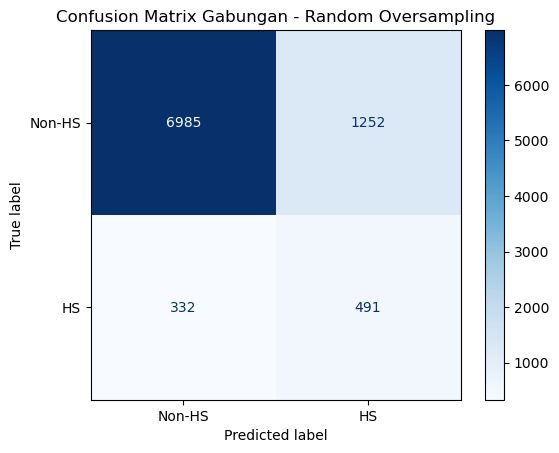

<Figure size 640x480 with 0 Axes>

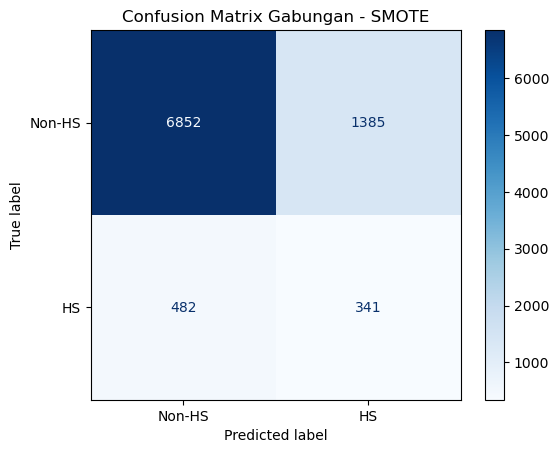

<Figure size 640x480 with 0 Axes>

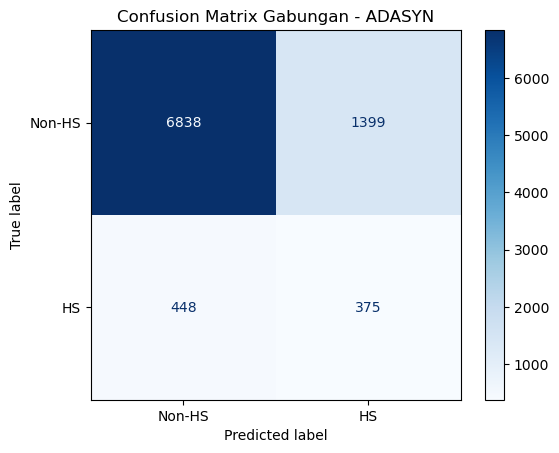


Perbandingan Metrik Kinerja Model (Rata-rata Cross-Validation):
   accuracy  precision    recall  f1_score            technique
0  0.825166   0.291403  0.596718  0.385568  Random Oversampling
1  0.793929   0.199240  0.414331  0.268252                SMOTE
2  0.796137   0.217655  0.455543  0.291296               ADASYN


<Figure size 640x480 with 0 Axes>

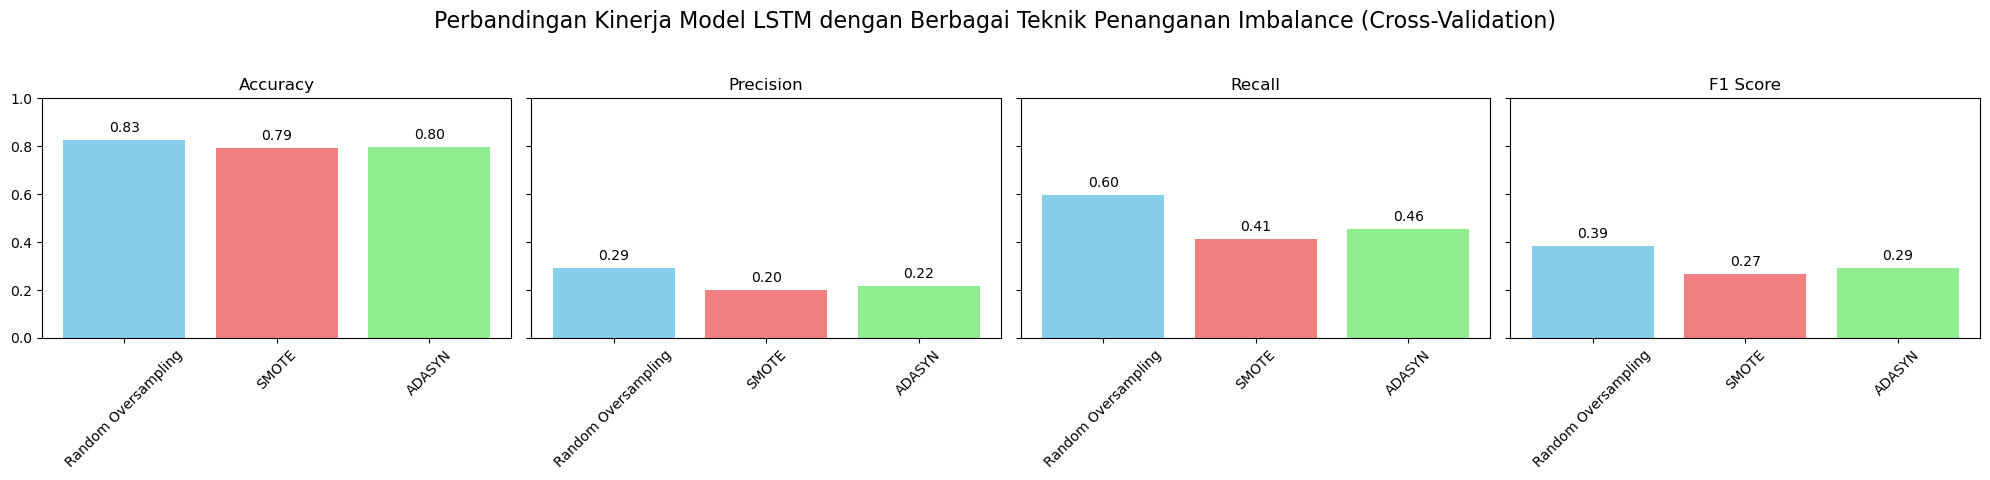

In [21]:
#Implementasi K-Fold Cross-Validation untuk Setiap Teknik Oversampling
n_splits = 5 # Jumlah folds untuk cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

from tqdm import tqdm
import time

all_results = {}
confusion_matrices = {}

# List teknik penanganan imbalance dan inisialisasi objeknya
oversampling_methods = {
    "Random Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
}

for tech_name, oversampler in oversampling_methods.items():
    fold_metrics = []
    all_y_true = []
    all_y_pred = []

    print(f"\n--- Starting {n_splits}-Fold Cross-Validation for {tech_name} ---")
    start_time = time.time()
    
    # Loop melalui setiap fold Stratified K-Fold
    # skf.split akan membagi X_data_for_cv dan y_data_for_cv (seluruh dataset)
    for fold_idx, (train_idx, val_idx) in tqdm(enumerate(skf.split(X_cv, y_cv)), total=n_splits):
        # Ambil data pelatihan dan validasi untuk fold saat ini (data asli)
        X_train_fold_orig, X_val_fold_orig = X_cv[train_idx], X_cv[val_idx]
        y_train_fold_orig, y_val_fold_orig = y_cv[train_idx], y_cv[val_idx]
        
        X_train_fold_resampled, y_train_fold_resampled = oversampler.fit_resample(X_train_fold_orig, y_train_fold_orig)
        print(f"Fold {fold_idx+1} - Resampled training set distribution ({tech_name}): {Counter(y_train_fold_resampled)}")

        # Latih dan evaluasi model pada fold ini
        metrics = train_and_evaluate_single_fold(
            X_train_fold_resampled, y_train_fold_resampled,
            X_val_fold_orig, y_val_fold_orig, # Evaluasi pada data validasi asli (tidak di-oversample)
            fold_idx,
            tech_name, # Teruskan nama teknik ke fungsi evaluasi
        )

        fold_metrics.append(metrics)
        all_y_true.extend(metrics['y_true'])
        all_y_pred.extend(metrics['y_pred'])

        print(f"Waktu untuk {tech_name}: {time.time() - start_time:.2f} detik")
    
    # Confusion matrix gabungan untuk teknik ini
    cm = confusion_matrix(all_y_true, all_y_pred)
    confusion_matrices[tech_name] = cm

    # Rata-rata metrik
    metric_df = pd.DataFrame([{k: v for k, v in d.items() if k in ['accuracy', 'precision', 'recall', 'f1_score']} for d in fold_metrics])
    avg_metrics = metric_df.mean().to_dict()
    avg_metrics['technique'] = tech_name
    all_results[tech_name] = avg_metrics

    print(f"\nAverage Metrics for {tech_name} across {n_splits} folds:")
    print(avg_metrics)

# Visualisasi confusion matrix per teknik
print("\nVisualisasi Confusion Matrix Gabungan untuk Setiap Teknik Oversampling:")
for tech_name, cm in confusion_matrices.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-HS', 'HS'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix Gabungan - {tech_name}')
    plt.show()
    plt.savefig(f"confusion_matrix_{tech_name}.png", dpi=300, bbox_inches='tight')

# Konversi hasil evaluasi ke DataFrame
results_df = pd.DataFrame(list(all_results.values()))
print("\nPerbandingan Metrik Kinerja Model (Rata-rata Cross-Validation):")
print(results_df)

# Plot perbandingan metrik
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), figsize=(20, 5), sharey=True)
fig.suptitle('Perbandingan Kinerja Model LSTM dengan Berbagai Teknik Penanganan Imbalance (Cross-Validation)', fontsize=16)

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(results_df['technique'], results_df[metric], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    axes[i].set_title(metric.replace('_', ' ').title())
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    for index, row in results_df.iterrows():
        axes[i].text(index, row[metric] + 0.02, f"{row[metric]:.2f}", ha='center', va='bottom')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()